In [27]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'cs231n_assignment3'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n_assignment3/cs231n/datasets
/content/drive/My Drive/cs231n_assignment3


## Using GPU

Go to `Runtime > Change runtime type` and set `Hardware accelerator` to `GPU`. This will reset Colab. **Rerun the top cell to mount your Drive again.**

# Generative Adversarial Networks (GANs)

So far in CS 231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we had learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$) and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will alternate between taking gradient *descent* steps on the objective for $G$ and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__.
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Here's an example of what your outputs from the 3 different models you're going to train should look like. Note that GANs are sometimes finicky, so your outputs might not look exactly like this. This is just meant to be a *rough* guideline of the kind of quality you can expect:

生成对抗网络（GANs）
到目前为止，在CS 231N中，我们探索的所有神经网络应用都是判别模型，这些模型接受输入并经过训练以产生标记的输出。这包括从图像类别的直接分类到句子生成（这仍然是一个分类问题，我们的标签在词汇空间中，我们已经学会了捕捉多词标签的递归）。在本笔记本中，我们将扩展我们的重复，并使用神经网络构建生成模型。具体来说，我们将学习如何构建模型，生成类似于一组训练图像的新图像。

什么是GAN？
2014年，Goodfellow等人提出了一种训练生成模型的方法，称为生成对抗网络（简称GANs）。在GAN中，我们构建了两个不同的神经网络。我们的第一个网络是一个传统的分类网络，称为鉴别器。我们将训练鉴别器拍摄图像，并将其分类为真实（属于训练集）或虚假（不存在于训练集中）。我们的另一个网络，称为生成器，将随机噪声作为输入，并使用神经网络对其进行转换以生成图像。生成器的目标是欺骗鉴别器，使其认为生成的图像是真实的。

我们可以把生成器（G）试图欺骗鉴别器（D）和鉴别器试图正确分类真实与虚假的来回过程想象成一个极大极小博弈：
minimizeGmaximizeDEx∼pdata[logD（x）]+Ez \8764》p（z）[log（1-D（G（z））]
其中z∼p（z）是随机噪声样本，G（z）使用神经网络生成器G生成的图像，D是鉴别器的输出，指定输入为实数的概率。在Goodfellow等人的研究中，他们分析了这种极小极大博弈，并展示了它如何与最小化训练数据分布和G生成的样本之间的Jensen Shannon散度有关。

为了优化这个极小极大博弈，我们将在G的目标上采取梯度下降步骤和D的目标上采用梯度上升步骤之间交替：

更新生成器（G）以最小化鉴别器做出正确选择的概率。
更新鉴别器（D）以使鉴别器做出正确选择的概率最大化。
虽然这些更新对分析很有用，但在实践中表现不佳。相反，当我们更新生成器时，我们将使用不同的目标：最大化鉴别器做出错误选择的概率。当鉴别器确信时，这个小变化有助于缓解发生器梯度消失的问题。这是大多数GAN论文中使用的标准更新，并在Goodfellow等人的原始论文中使用。。

在本次作业中，我们将交替进行以下更新：

更新生成器（G），以最大限度地提高鉴别器对生成的数据做出错误选择的概率：
最大化GEz∼p（z）[logD（G（z））]
更新鉴别器（D），以使鉴别器在真实和生成的数据上做出正确选择的概率最大化：
maxizeDEx∼pdata[logD（x）]+Ez W p（z）[log（1-D（G（z））]
这里有一个例子，说明你要训练的3个不同模型的输出应该是什么样子。请注意，GAN有时很挑剔，所以你的输出可能不完全像这样。这只是一个粗略的指导方针，说明你可以期望的质量：

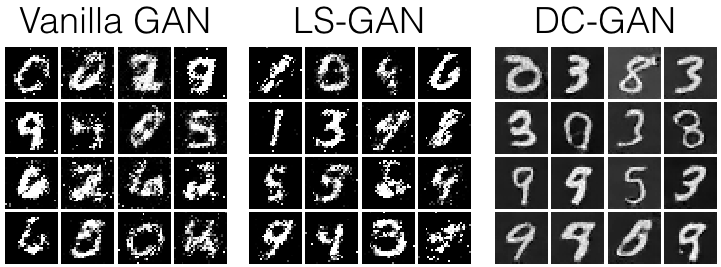

In [2]:
# Run this cell to see sample outputs.
from IPython.display import Image
Image('images/gan_outputs_pytorch.png')

In [3]:
# Setup cell.
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cs231n.gan_pytorch import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

answers = dict(np.load('gan-checks.npz'))
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`.

数据集
众所周知，GAN对超参数非常挑剔，也需要许多训练周期。为了使这项任务变得可行，我们将研究MNIST数据集，其中包括60000个训练图像和10000个测试图像。每张图片都包含一个黑色背景上白色数字的中心图像（0到9）。这是用于训练卷积神经网络的首批数据集之一，它相当简单——标准的CNN模型可以很容易地超过99%的准确率。

为了简化我们的代码，我们将使用PyTorch MNIST包装器，它下载并加载MNIST数据集。有关接口的更多信息，请参阅文档。默认参数将选取5000个训练示例，并将其放入验证数据集中。数据将保存到名为MNIST_data的文件夹中。

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 137kB/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw



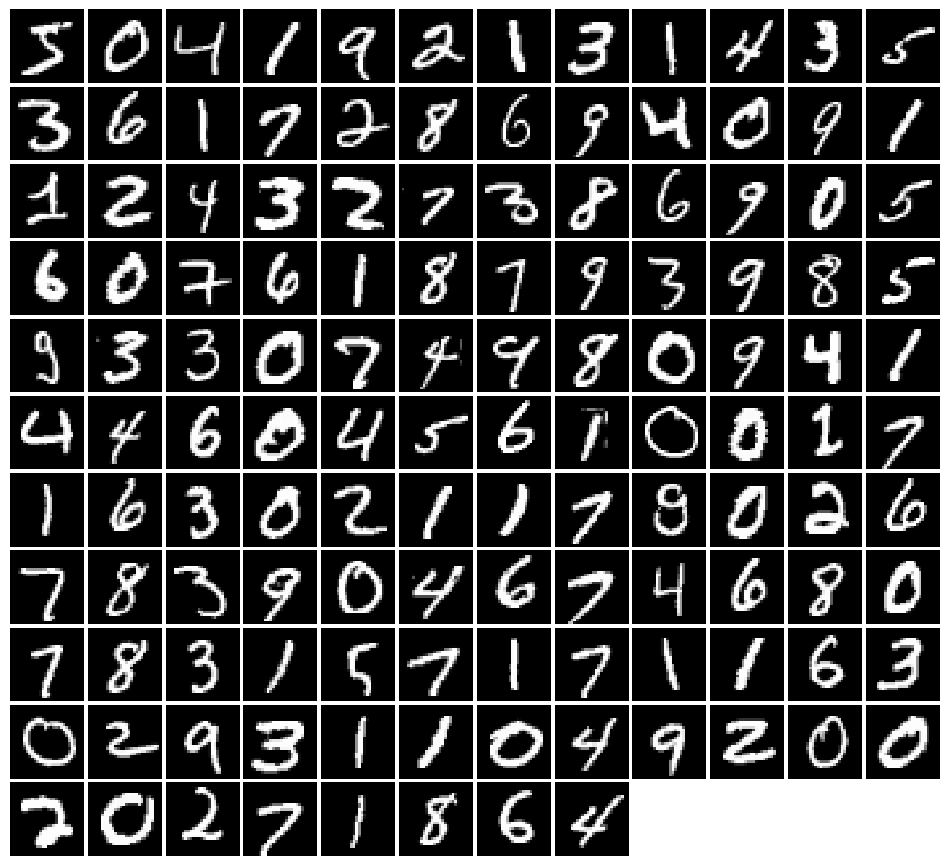

In [4]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_TRAIN, 0)
)

mnist_val = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)
)

iterator = iter(loader_train)
imgs, labels = next(iterator)
imgs = imgs.view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Implement `sample_noise` in `cs231n/gan_pytorch.py`.

Hint: use `torch.rand`.

Make sure noise is the correct shape and type:

随机噪声
使用形状[batch_size，dim]生成-1到1的均匀噪声。

在cs231n/gan_pytorch.py中实现sample_noise。

提示：使用torch.rand。

确保噪音的形状和类型正确：

In [6]:
from cs231n.gan_pytorch import sample_noise

def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')

test_sample_noise()

All tests passed!


## Flatten

Recall our Flatten operation from previous notebooks... this time we also provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

平坦
回想一下以前笔记本中的Flatten操作。。。这次我们还提供了一个Unflatten，您可能希望在实现卷积生成器时使用它。我们还提供了一个权重初始化器（并为您调用），它使用Xavier初始化，而不是PyTorch的统一默认值。

In [7]:
from cs231n.gan_pytorch import Flatten, Unflatten, initialize_weights

# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1

Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.

The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

Implement `discriminator` in `cs231n/gan_pytorch.py`

歧视者
我们的第一步是建立一个鉴别器。将架构作为nn的一部分填写。下面函数中的顺序构造函数。所有完全连接的层都应该包含偏置项。架构为：

全连接层，输入大小784，输出大小256
LeakyReLU，alpha 0.01
输入大小为256，输出大小为256的全连接层
LeakyReLU，alpha 0.01
全连接层，输入大小为256，输出大小为1
回想一下，Leaky ReLU非线性计算某个固定常数α的f（x）=max（αx，x）；对于上述架构中的LeakyReLU非线性，我们设置α=0.01。

鉴别器的输出应具有形状[batch_size，1]，并包含与每个batch_sizes输入都是真实图像的分数相对应的实数。

在cs231n/gan_pytorch.py中实现鉴别器

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
from cs231n.gan_pytorch import discriminator

def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')

test_discriminator()

Correct number of parameters in discriminator.


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

 Implement `generator` in `cs231n/gan_pytorch.py`

Test to make sure the number of parameters in the generator is correct:

In [9]:
from cs231n.gan_pytorch import generator

def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation that relies on PyTorch's `nn.BCEWithLogitsLoss`.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch. This is taken care of in `bce_loss` which combines the loss by averaging.

Implement `discriminator_loss` and `generator_loss` in `cs231n/gan_pytorch.py`

GAN损失
计算发生器和鉴别器的损耗。发电机损耗为：
ℓG=−Ez∼p（z）[logD（G（z））]
鉴别器损耗为：
ℓD=−Ex∼pdata[logD（x）]−Ez \8764》p（z）[log（1-D（G（z））]
请注意，这些是从前面给出的方程中否定的，因为我们将使这些损失最小化。

提示：您应该使用下面定义的bce_loss函数来计算二进制交叉熵损失，这是在鉴别器输出logits的情况下计算真实标签的对数概率所必需的。给定分数s∈R和标签y∈{0,1}，二元交叉熵损失为

bce（s，y）=−y*log（s）−（1-y）*log（1-s）

这个公式的简单实现可能在数值上不稳定，因此我们提供了一个依赖于PyTorch神经网络的数值稳定的实现。BCE物流损失。

您还需要计算与真实或虚假相对应的标签，并使用logit参数来确定它们的大小。确保使用全局dtype变量将这些标签转换为正确的数据类型，例如：

true_labels=torch.ones（大小）.type（数据类型）

我们将对小批量的元素进行平均，而不是计算logD（G（z））、logD（x）和log（1-D（G））的期望值。这在bce_loss中得到了处理，它通过求平均值来组合损失。

在cs231n/gan_pytorch.py中实现鉴别器_loss和生成器_loss

Test your generator and discriminator loss. You should see errors < 1e-7.

In [12]:
from cs231n.gan_pytorch import bce_loss, discriminator_loss, generator_loss

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_true']
)

Maximum error in d_loss: 3.97058e-09


In [13]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(
    answers['logits_fake'],
    answers['g_loss_true']
)

Maximum error in g_loss: 4.4518e-09


# Optimizing our Loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

Implement `get_optimizer` in `cs231n/gan_pytorch.py`

优化我们的损失
创建一个返回optim的函数。Adam优化器用于给定模型，学习率为1e-3，beta1=0.5，beta2=0.999。您将使用它为生成器构建优化器，并为笔记本的其余部分构建鉴别器。

在cs231n/gan_pytorch.py中实现get_optimizer

# Training a GAN!

We provide you the main training loop. You won't need to change `run_a_gan` in `cs231n/gan_pytorch.py`, but we encourage you to read through it for your own understanding.

In [23]:
from cs231n.gan_pytorch import get_optimizer, run_a_gan

# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run it!
images = run_a_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    loader_train
)

Iter: 0, D: 1.458, G:0.7192
Iter: 250, D: 1.657, G:0.8955
Iter: 500, D: 1.069, G:1.415
Iter: 750, D: 1.181, G:0.8313
Iter: 1000, D: 1.095, G:1.082
Iter: 1250, D: 1.049, G:1.045
Iter: 1500, D: 1.222, G:1.112
Iter: 1750, D: 1.256, G:1.045
Iter: 2000, D: 1.277, G:0.9257
Iter: 2250, D: 1.251, G:0.9283
Iter: 2500, D: 1.357, G:0.8798
Iter: 2750, D: 1.231, G:0.8809
Iter: 3000, D: 1.301, G:0.8456
Iter: 3250, D: 1.311, G:0.7586
Iter: 3500, D: 1.265, G:0.8464
Iter: 3750, D: 1.265, G:0.796


Run the cell below to show the generated images.

Iter: 0


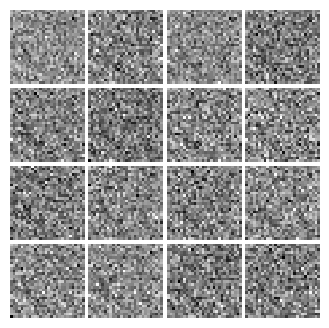


Iter: 250


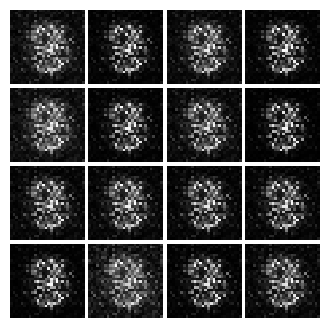


Iter: 500


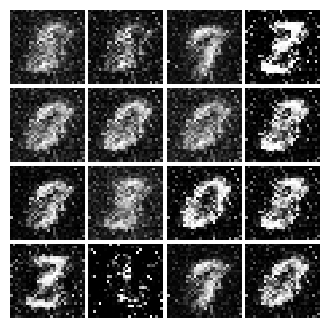


Iter: 750


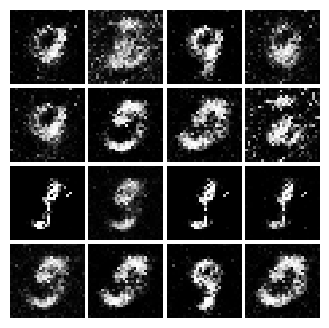


Iter: 1000


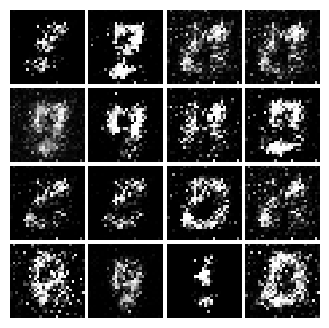


Iter: 1250


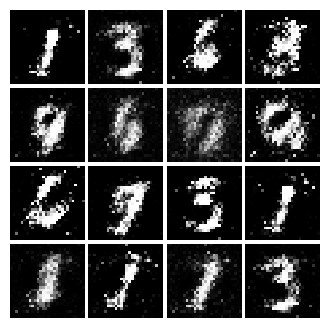


Iter: 1500


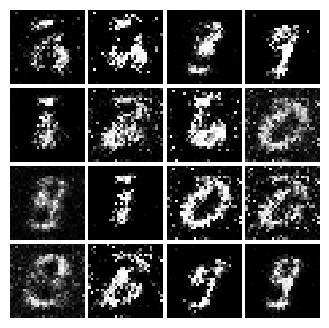


Iter: 1750


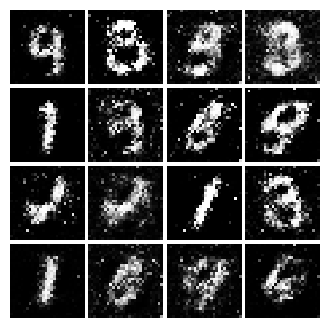


Iter: 2000


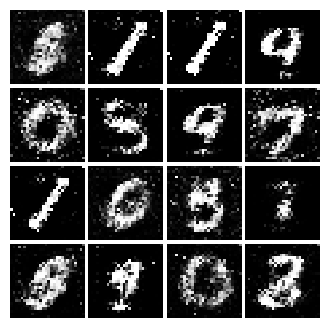


Iter: 2250


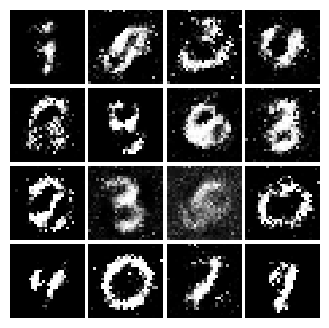


Iter: 2500


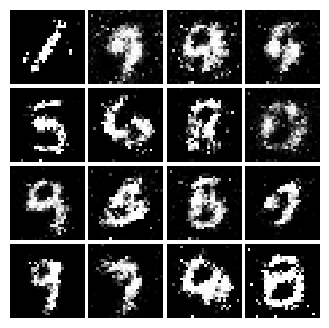


Iter: 2750


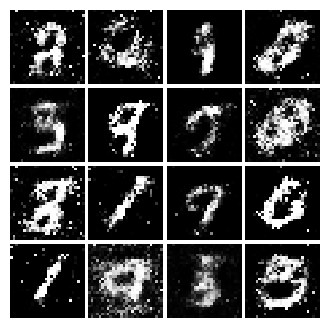


Iter: 3000


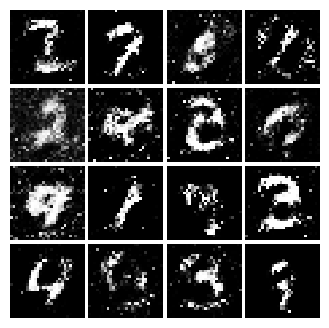


Iter: 3250


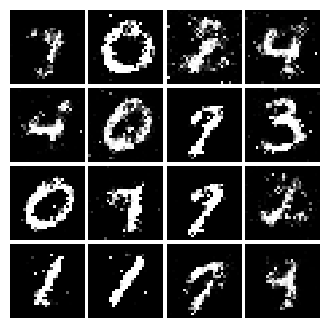


Iter: 3500


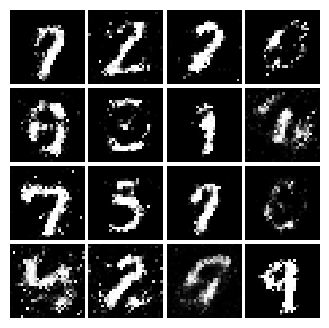


Iter: 3750


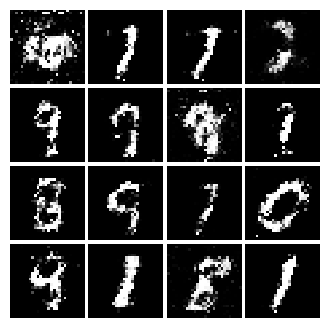

In [24]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 1

What does your final vanilla GAN image look like?

随着迭代次数的增加 图片逐渐变得清晰 更容易辨认

Vanilla GAN final image:


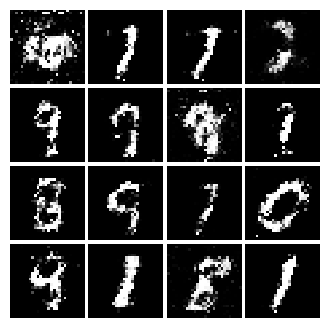

In [25]:
# This output is your answer.
print("Vanilla GAN final image:")
show_images(images[-1])
plt.show()

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

嗯，这并不难，是吗？在100秒以下的迭代中，当你接近迭代1000时，你应该看到黑色背景、模糊的形状和体面的形状，当我们超过3000时，其中大约一半的形状会变得清晰可辨。



# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

Implement `ls_discriminator_loss`, `ls_generator_loss` in `cs231n/gan_pytorch.py`

最小二乘GAN
我们现在来看看最小二乘GAN，它是原始GAN损失函数的更新、更稳定的变体。对于这一部分，我们所要做的就是改变损失函数并重新训练模型。我们将在论文中实现方程式（9），其中包含发电机损耗：
ℓG=12Ez∼p（z）[（D（G（z））-1）2]
以及鉴别器损失：
ℓD=12Ex∼pdata[（D（x）-1）2]+12Ez∤p（z）[（D

提示：我们将对小批量的元素进行平均，而不是计算期望值，因此请确保通过平均而不是求和来组合损失。当插入D（x）和D（G（z））时，使用鉴别器的直接输出（scores_real和scores_fake）。

在cs231n/gan_pytorch.py中实现ls_discrimitor_loss、ls_generator_loss

Before running a GAN with our new loss function, let's check it:

In [28]:
from cs231n.gan_pytorch import ls_discriminator_loss, ls_generator_loss

def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_lsgan_true'],
    answers['g_loss_lsgan_true']
)

Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


Run the following cell to train your model!

In [29]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

images = run_a_gan(
    D_LS,
    G_LS,
    D_LS_solver,
    G_LS_solver,
    ls_discriminator_loss,
    ls_generator_loss,
    loader_train
)

Iter: 0, D: 0.5199, G:0.4814
Iter: 250, D: 0.2487, G:0.2375
Iter: 500, D: 0.1312, G:0.5086
Iter: 750, D: 0.1807, G:0.3666
Iter: 1000, D: 0.2305, G:0.2694
Iter: 1250, D: 0.2239, G:0.1195
Iter: 1500, D: 0.2048, G:0.1884
Iter: 1750, D: 0.2302, G:0.1899
Iter: 2000, D: 0.2274, G:0.2664
Iter: 2250, D: 0.2507, G:0.1502
Iter: 2500, D: 0.2238, G:0.1652
Iter: 2750, D: 0.2247, G:0.1799
Iter: 3000, D: 0.2465, G:0.1495
Iter: 3250, D: 0.2114, G:0.1415
Iter: 3500, D: 0.2324, G:0.15
Iter: 3750, D: 0.2368, G:0.1515


Run the cell below to show generated images.

Iter: 0


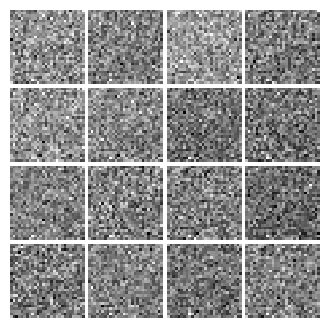


Iter: 250


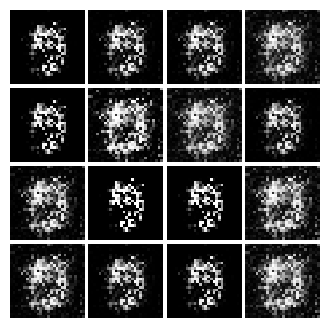


Iter: 500


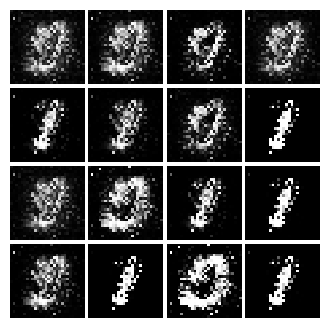


Iter: 750


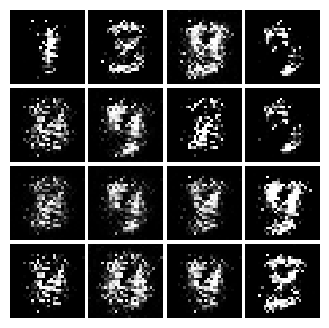


Iter: 1000


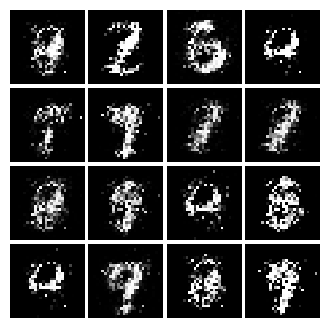


Iter: 1250


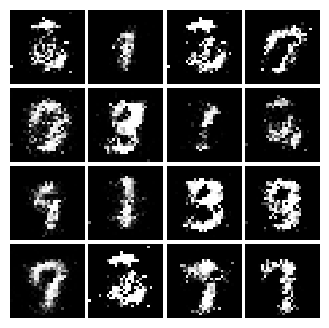


Iter: 1500


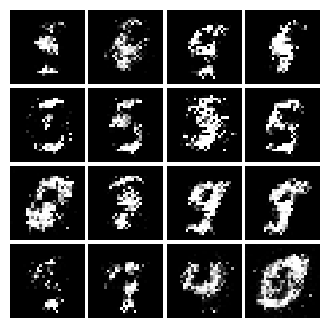


Iter: 1750


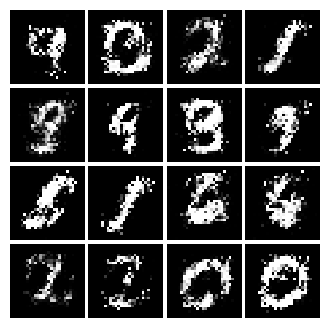


Iter: 2000


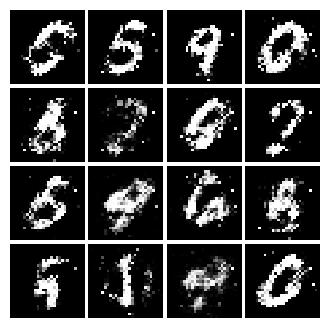


Iter: 2250


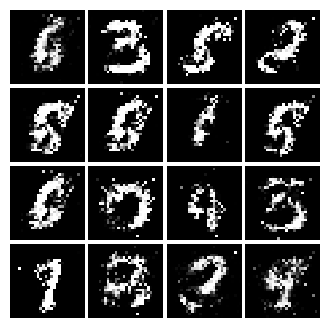


Iter: 2500


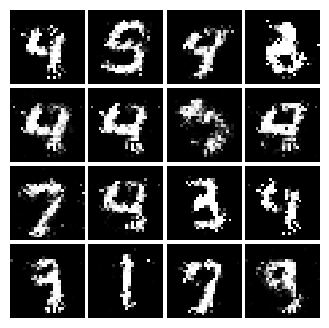


Iter: 2750


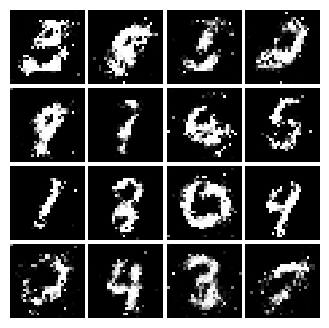


Iter: 3000


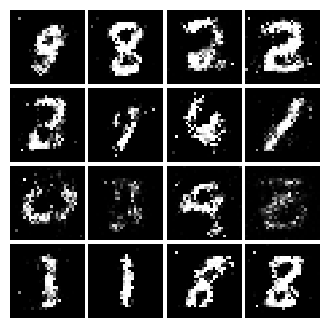


Iter: 3250


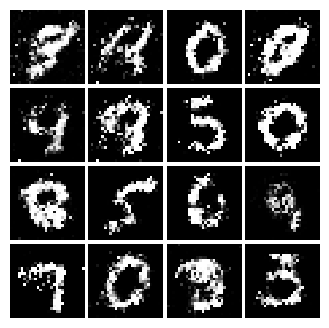


Iter: 3500


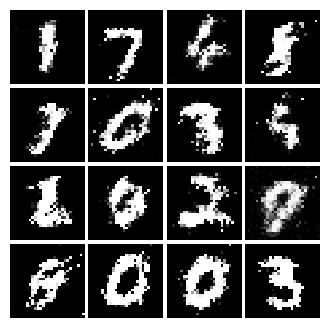


Iter: 3750


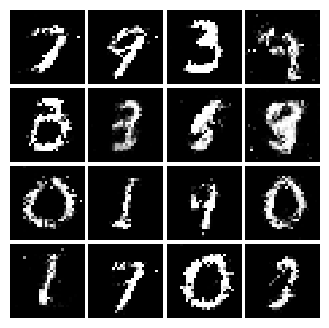

In [30]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 2

What does your final LSGAN image look like?

和上面一样的过程 但是变得清晰的速度明显加快

LSGAN final image:


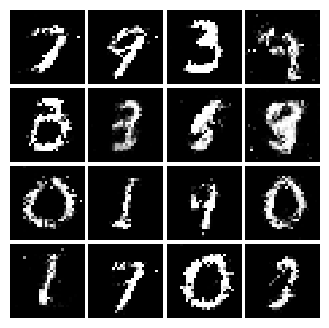

In [31]:
# This output is your answer.
print("LSGAN final image:")
show_images(images[-1])
plt.show()

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly.
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Implement `build_dc_classifier` in `cs231n/gan_pytorch.py`

深度卷积GAN
在笔记本的第一部分，我们实现了Ian Goodfellow的原始GAN网络的几乎直接副本。然而，这种网络架构不允许进行真正的空间推理。一般来说，它无法对“锐边”之类的东西进行推理，因为它缺乏任何卷积层。因此，在本节中，我们将实现DCGAN的一些想法，在DCGAN中我们使用卷积网络

歧视者
我们将使用受TensorFlow MNIST分类教程启发的鉴别器，该鉴别器能够相当快地在MNIST数据集上获得99%以上的准确率。

卷积2D：32个滤波器，5x5，步长1
Leaky ReLU（α=0.01）
最大泳池2x2，跨步2
卷积2D：64个滤波器，5x5，步长1
Leaky ReLU（α=0.01）
最大泳池2x2，跨步2
平坦
完全连接，输出尺寸为4 x 4 x 64
Leaky ReLU（α=0.01）
与输出尺寸1完全连接
在cs231n/gan_pytorch.py中实现build_dc_分类器

In [32]:
from cs231n.gan_pytorch import build_dc_classifier

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier(batch_size).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [33]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier(batch_size)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in classifier. Check your achitecture.')
    else:
        print('Correct number of parameters in classifier.')

test_dc_classifer()

Correct number of parameters in classifier.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). We are always "training" in GAN mode.
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128
* ReLU
* BatchNorm
* Use `Unflatten()` to reshape into Image Tensor of shape 7, 7, 128
* ConvTranspose2d: 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* ConvTranspose2d: 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector (using `Flatten()`)

Implement `build_dc_generator` in `cs231n/gan_pytorch.py`

In [34]:
from cs231n.gan_pytorch import build_dc_generator

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 1, 28, 28])

Check the number of parameters in your generator as a sanity check:

In [35]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


In [36]:
D_DC = build_dc_classifier(batch_size).type(dtype)
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(
    D_DC,
    G_DC,
    D_DC_solver,
    G_DC_solver,
    discriminator_loss,
    generator_loss,
    loader_train,
    num_epochs=5
)

Iter: 0, D: 1.327, G:1.085
Iter: 250, D: 2.055, G:1.71
Iter: 500, D: 1.253, G:0.9328
Iter: 750, D: 1.206, G:0.7387
Iter: 1000, D: 1.222, G:0.8293
Iter: 1250, D: 1.329, G:1.126
Iter: 1500, D: 1.107, G:1.025
Iter: 1750, D: 1.155, G:0.974


Run the cell below to show generated images.

Iter: 0


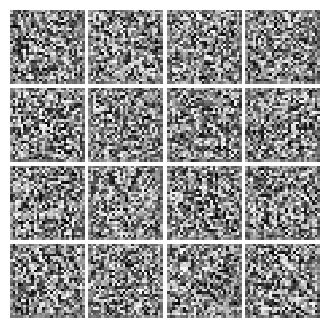


Iter: 250


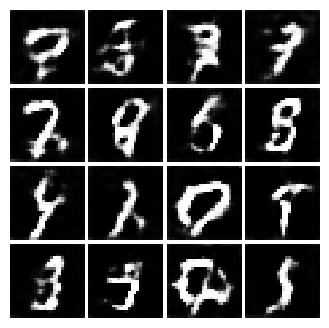


Iter: 500


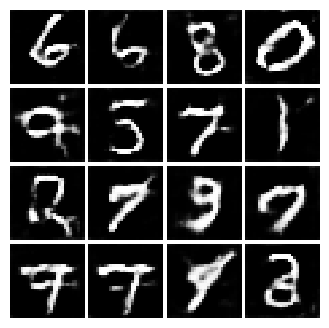


Iter: 750


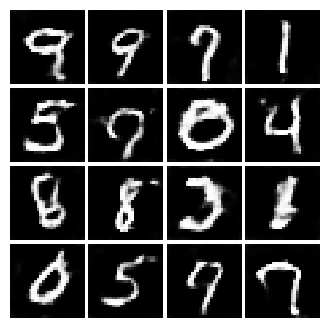


Iter: 1000


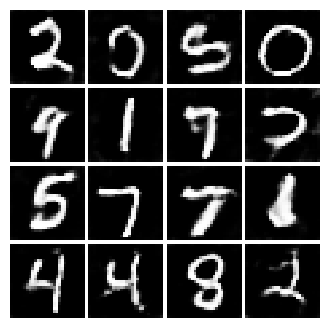


Iter: 1250


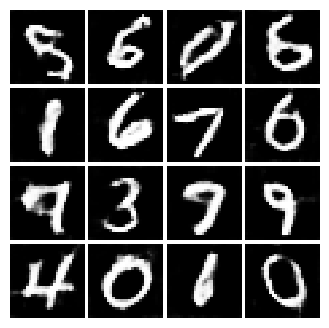


Iter: 1500


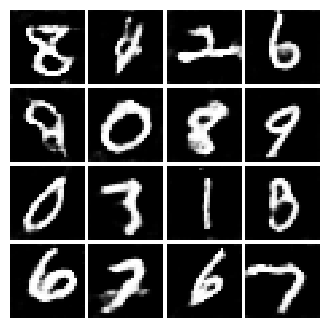


Iter: 1750


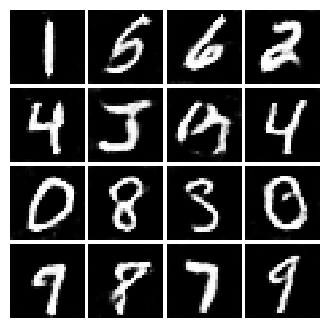

In [37]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 3

What does your final DCGAN image look like?

超快 超清晰！

DCGAN final image:


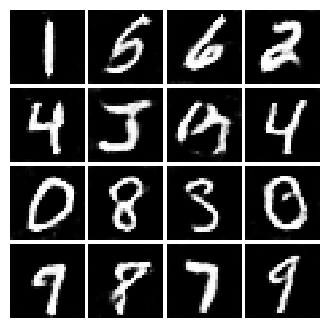

In [38]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()

## Inline Question 4

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$,
by using alternating gradient (first updating y, then updating x using that updated y) with step size $1$. **Here step size is the learning_rate, and steps will be learning_rate * gradient.**
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Breifly explain what $\min_x\max_y f(x,y)$ evaluates to and record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

### Your answer:


 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$
 ----- | ----- | ----- | ----- | ----- | ----- | -----
   1   | 2    1  |  -1    -2 |   -1   1 |       |       |       
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$
   1   | -1   -2   |-1    1   |  2    1 |       |       |       
   
应当为0 因为xy取得最小值 x为0 那么y无论多大值 值为0



## Inline Question 5
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer:
很明显不可能 并没有收敛的趋势

## Inline Question 6
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient.

### Your answer:

在线问题4
我们将通过一个例子来了解为什么交替最小化同一目标（就像在GAN中一样）可能是一件棘手的事情。

考虑f（x，y）=xy。minxmaxyf（x，y）的计算结果是什么？（提示：minmax试图最小化可实现的最大值。）

现在，尝试使用步长为1的交替梯度（首先更新y，然后使用更新的y更新x），从点（1,1）开始，对该函数进行6步数值计算。这里的步长是learning_rate，步长将是learning_rate*梯度。你会发现，用xt、yt、xt+1、yt+1来写更新步骤会很有用。

简要解释minxmaxyf（x，y）的计算结果，并在下表中记录（xt，yt）的六对显式值。

你的答案：
y0 y1 y2 y3 y4 y5 y6
1.
x0 x1 x2 x3 x4 x5 x6
1.
内联问题5
使用这种方法，我们会达到最优值吗？为什么或为什么不呢？

你的答案：
内联问题6
如果训练期间发电机损耗降低，而鉴别器损耗从一开始就保持在恒定的高值，这是一个好兆头吗？为什么或为什么不呢？定性的答案就足够了。


不是 因为最优化的过程的目的是loss的下降 而一者居高不下说明没有进行成功或者有效率的优化 并不是好事
